# Project 1, Part 6, Best Recommendation

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Stephanie Cabanela

Year: 2022

Semester: Spring

Section: 7


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# Source for this cell: Lab 2

#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to Postgres database
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()

## The executives would like your best recommendation for the business. 

## Create an executive summary giving and explaining your best recommendation for the business. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

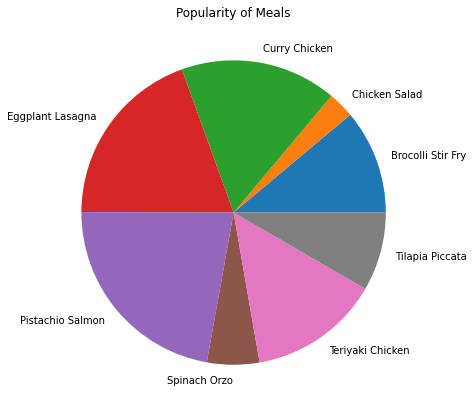

In [3]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select pd.description as meal_name, 
    sum(li.quantity) as total_meals_purchased
from stores as st
    join sales as sa on st.store_id = sa.store_id
    join line_items as li on sa.store_id = li.store_id and sa.sale_id = li.sale_id
    join products as pd on li.product_id = pd.product_id
group by meal_name

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
plt.figure(figsize=(7,7))
plt.pie(df['total_meals_purchased'], labels=df['meal_name'])
plt.title('Popularity of Meals')
plt.show()

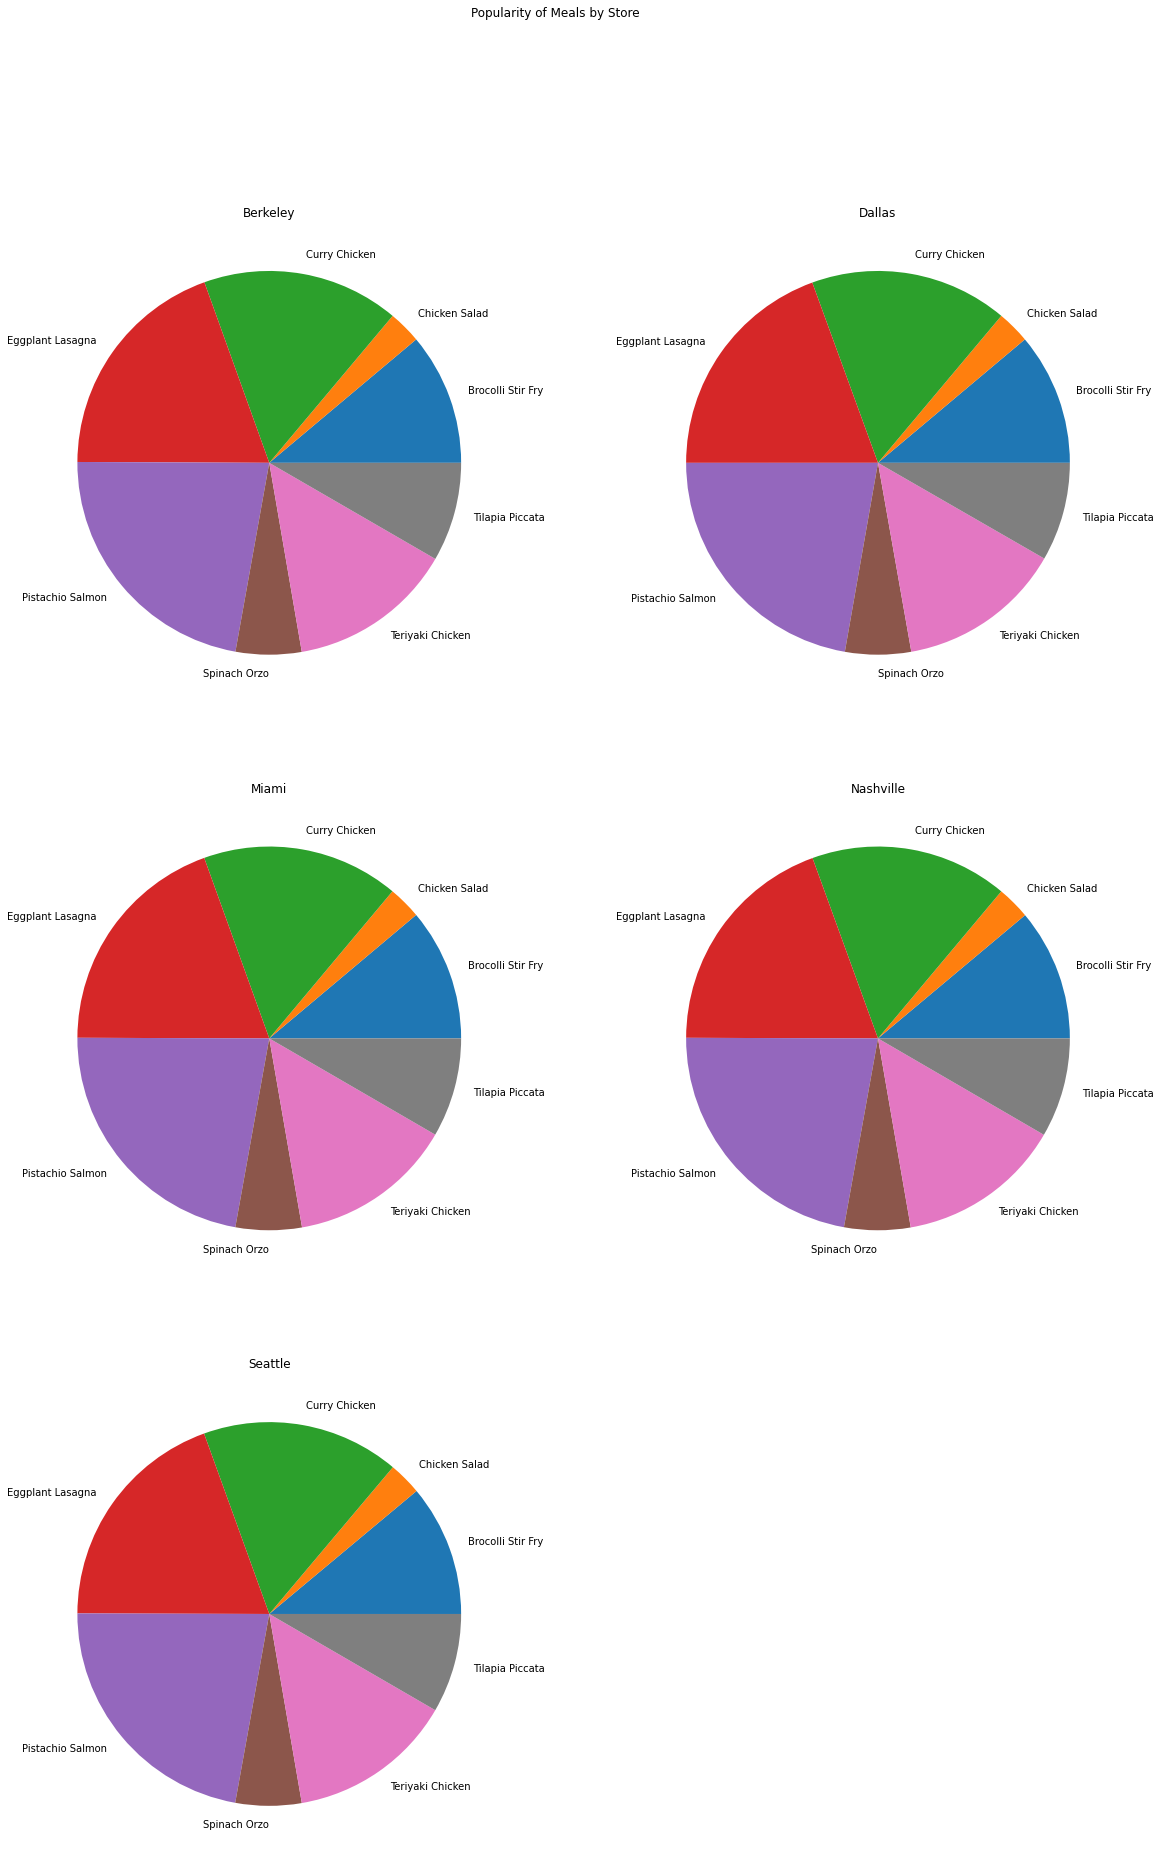

In [4]:
rollback_before_flag = True
rollback_after_flag = True


query = """

select *
from crosstab(
    '
        select meal_name, store_name, total_meals_purchased
        from
            (
            select st.city as store_name, 
                pd.description as meal_name, 
                sum(li.quantity) as total_meals_purchased
            from stores as st
                join sales as sa on st.store_id = sa.store_id
                join line_items as li on sa.store_id = li.store_id and sa.sale_id = li.sale_id
                join products as pd on li.product_id = pd.product_id
            group by meal_name, store_name
            order by meal_name, store_name
            ) as a
    ')
as ("meal_name" varchar, "Berkeley" numeric, "Dallas" numeric, 
        "Miami" numeric, "Nashville" numeric, "Seattle" numeric)

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

fig, ax = plt.subplots(3, 2, figsize=(20,30))
fig.suptitle('Popularity of Meals by Store')

days = ['Berkeley', 'Dallas', 'Miami', 'Nashville', 'Seattle']

day_count = 0

for i in range(0,3):
    for j in range(0,2):
        if not (i == 2 and j == 1):
            ax[i][j].pie(df[days[day_count]], labels=df['meal_name'])
            ax[i][j].set_title(days[day_count])
        day_count += 1
fig.delaxes(ax[2,1])

In [5]:
rollback_before_flag = True
rollback_after_flag = True


query = """

select split_part(meal_list,',',1) as meal1,
    split_part(meal_list,',',2) as meal2
from (    select sa.store_id, sa.sale_id, sa.sale_date,
        count(li.line_item_id) as count_line_items,
        string_agg(pd.description, ', ') as meal_list
    from stores as st
        join sales as sa on st.store_id = sa.store_id
        join line_items as li on sa.store_id = li.store_id and sa.sale_id = li.sale_id
        join products as pd on li.product_id = pd.product_id
    group by sa.store_id, sa.sale_id
    having count(li.line_item_id) = 2 and string_agg(pd.description, ', ') like '%Chicken Salad%') as a

"""

chicken_partner_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

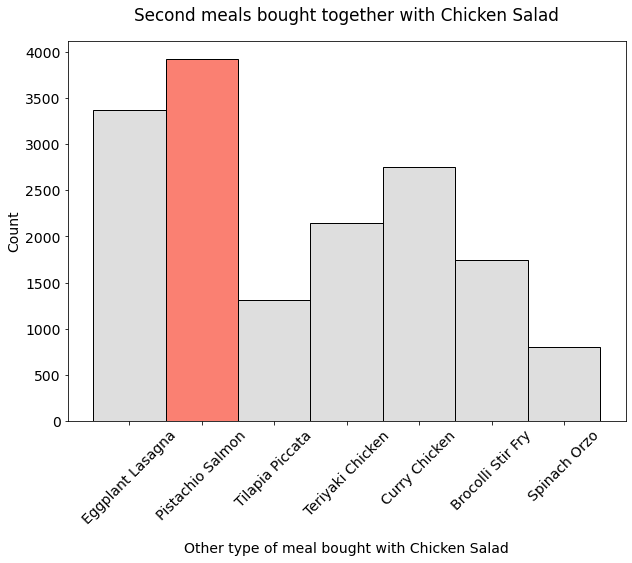

In [6]:
chicken_partner = chicken_partner_df.copy()
chicken_partner['partner_meal'] = 'Chicken Salad'
chicken_partner['partner_meal'] = np.where(chicken_partner['meal1'] == 'Chicken Salad', chicken_partner['meal2'], chicken_partner['meal1'])
chicken_partner['partner_meal'] = chicken_partner['partner_meal'].str.strip()

highlight_color = 'turquoise'
regular_color = 'lightgrey'

plt.figure(figsize=(10,7))
plt.rcParams['font.size'] = 14
plt.title('Second meals bought together with Chicken Salad', pad=20)
plt.xlabel('Other type of meal bought with Chicken Salad', labelpad=15)
ax = sns.histplot(data = chicken_partner['partner_meal'], color='lightgrey')
heights = [patch.get_height() for patch in ax.patches]
max_height = np.argmax(heights)
ax.patches[max_height].set_facecolor('salmon')
plt.xticks(rotation=45)
plt.show()

In [7]:
rollback_before_flag = True
rollback_after_flag = True


query = """

select split_part(meal_list,',',1) as meal1,
    split_part(meal_list,',',2) as meal2
from (    select sa.store_id, sa.sale_id, sa.sale_date,
        count(li.line_item_id) as count_line_items,
        string_agg(pd.description, ', ') as meal_list
    from stores as st
        join sales as sa on st.store_id = sa.store_id
        join line_items as li on sa.store_id = li.store_id and sa.sale_id = li.sale_id
        join products as pd on li.product_id = pd.product_id
    group by sa.store_id, sa.sale_id
    having count(li.line_item_id) = 6 and string_agg(pd.description, ', ') like '%Chicken Salad%') as a

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,meal1,meal2
0,Spinach Orzo,Chicken Salad
1,Eggplant Lasagna,Teriyaki Chicken
2,Eggplant Lasagna,Chicken Salad
3,Pistachio Salmon,Teriyaki Chicken
4,Curry Chicken,Teriyaki Chicken
...,...,...
45614,Curry Chicken,Pistachio Salmon
45615,Eggplant Lasagna,Chicken Salad
45616,Tilapia Piccata,Curry Chicken
45617,Curry Chicken,Pistachio Salmon
